In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from fastai.structured import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from IPython.core.debugger import set_trace
from sklearn.model_selection import KFold
plt.rcParams[‘font.sans-serif’] = [‘Microsoft YaHei’]
# import os
# print(os.listdir("./"))
# PATH = "./"


In [2]:
# parse_dates是将日期类的数据解析成日期类型
df_train = pd.read_csv(r'E:\restaurant\train.csv\train.csv', parse_dates=['Open Date'])
df_test = pd.read_csv(r'E:\restaurant\test.csv\test.csv', parse_dates=['Open Date'])

df_joined = pd.concat([df_train.drop('revenue', axis=1), df_test], axis=0)  # 合并数据集

In [3]:
def score(model, X_train, y_train, X_valid = [], y_valid = []):  # 计算得分  均方误差
    #set_trace()
    rms = sqrt(mean_squared_error(np.square(np.exp(y_train)), np.square(np.exp(model.predict(X_train)))))
    score = [rms, model.score(X_train, y_train)]
    
    if len(X_valid) != 0 and len(y_valid) != 0:
        score.append(sqrt(mean_squared_error(np.square(np.exp(y_valid)), np.square(np.exp(model.predict(X_valid))))))
        
    if model.oob_score:   
        '''
        oob_score:袋外估计(out-of-bag)，这个外是针对于bagging这个袋子而言的，
        我们知道，bagging采取的随机抽样的方式去建立树模型，那么那些未被抽取到的样本集，
        也就是未参与建立树模型的数据集就是袋外数据集，我们就可以用这部分数据集去验证模型效果，默认值为False。
        '''
        score.append(model.oob_score_)
    
    return score

n_train = df_train.shape[0]

def prcs(df, fe=[]):
#     add_datepart(df, 'Open Date')  # 这是个将日期转化成数值型的linux函数,换下面的函数
    from datetime import datetime
    df['age'] = (datetime.now() - df['Open Date']).astype('timedelta64[D]') / 365
    df = df.drop('Open Date', axis=1) # axis=1删除列
    
    if 'city' in fe:
        df = df.drop('City', axis=1)
    # Quitamos el outlier (16)  # 删除某一列有异常值的那一行
    if 'outlier' in fe:
        df = df.drop(index=16, axis=0)
    
    if 'MB' in fe:
        # No hay apenas tipo 'MB'
        df['Type'] = df['Type'].replace('MB', 'DT')
    
    if 'city_group' in fe:
        df = df.drop('City Group', axis=1)
    
    if 'dummies' in fe:
        #Get dummies
        p_cols = [ f'P{n}' for n in range(1,38)]
            
        df = pd.get_dummies(df, columns=p_cols)   # 对P1-P37列进行独热编码   其实可以用LabelEncoder
        if 'city_group' not in fe:
            df = pd.get_dummies(df, columns=['City Group'], drop_first=True)
        df = pd.get_dummies(df, columns=['Type'])
    
    #Train cats  将类别转换为数字
#     train_cats(df)  函数不可用!!下面替换
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for col in df:
        if df.dtypes[col] == 'object':
            df[col] = le.fit_transform(df[col].values)  # 润佳  我真是太厉害了
    
    
#     X, _, _ = proc_df(df, None)  # 没有缺失 用不了fastai  弃掉  用以上函数代替
    '''
    可调用proc_df函数将所有分类数据转换为整数代码
    该函数执行以下任务：
    1. 对于连续变量，它检查列是否存在缺失值；
    2. 如果列有缺失值，则创建另一列名为 columnname_na，1代表有缺失值，0代表没有缺失值；
    3. 同时，缺失值被列的中值所代替；
    4. 对于分类变量，Pandas 用-1替换缺失值。因此，proc_df 为分类变量的所有值增加了1。因此，我们0代表缺失值，而所有其他值都递增1。
    
    返回  df, y, nas = proc_df(df_raw, 'SalePrice')
    '''
    
    X = df.copy()  # 上面的函数不可用   直接copy
    
    #  日期处理直接用数值代替了 这些参数列可能是add_datepart函数生成
#     drop_cols = ['Open Year', 'Open Month', 'Open Week', 'Open Day', 'Open Dayofweek',
#        'Open Dayofyear', 'Open Is_month_end', 'Open Is_month_start',
#        'Open Is_quarter_end', 'Open Is_quarter_start', 'Open Is_year_end',
#        'Open Is_year_start']
    
#     X = X.drop(drop_cols, axis=1)
    # La columna Id no aporta nada  Id列不会添加任何内容
    if 'id' in fe:
        X = X.drop('Id', axis=1)
    
    if 'scale_open' in fe:  # 不知道干嘛的
        X['Open Elapsed'] = (X['Open Elapsed']/1000).apply(np.log)
    
    X_train = X[:n_train]
    X_test = X[n_train:]   # 把数据集合在一起又分开???
    
    return X_train, X_test

def train_cv(X, y):
    models = []
    scores = []
    
    kf = KFold(n_splits=4, random_state=12, shuffle=False)  # 拆分为k个连续折叠
    for train_index, val_index in kf.split(X):
        X_train_ = X.iloc[train_index]  # iloc行切片 loc列切片
        y_train_ = y.iloc[train_index]
        X_val_ = X.iloc[val_index]
        y_val_ = y.iloc[val_index]
        m = RandomForestRegressor(n_jobs=-1, n_estimators=100, max_features=0.5, oob_score=True)
        m.fit(X_train_, y_train_)
        models.append(m)
        scores.append(score(m, X_train_, y_train_, X_val_, y_val_))
        
    return models, np.array(scores).mean(axis=0)

def predict(models, X):
    f = 1 / len(models)
    pred = 0
    for m in models:
        pred += f * m.predict(X)
    
    return pred

In [7]:
X_train, X_test = prcs(df_joined.copy())   # 特征工程  数据处理
# https://blog.csdn.net/xiaolang85/article/details/51604470
#  缩小数据的绝对数值，方便计算。  将乘法计算转换称加法计算。   在数据的整个值域中的在不同区间的差异带来的影响不同。
y_train = df_train['revenue'].copy().apply(np.log)   # 降一个指数级
print(X_train.head())
print(X_test.head())
print(y_train.head())

   Id  City  City Group  Type  P1   P2   P3   P4  P5  P6    ...      P29  P30  \
0   0    60           0     2   4  5.0  4.0  4.0   2   2    ...      3.0    5   
1   1     4           0     1   4  5.0  4.0  4.0   1   2    ...      3.0    0   
2   2    14           1     2   2  4.0  2.0  5.0   2   3    ...      3.0    0   
3   3    52           1     2   6  4.5  6.0  6.0   4   4    ...      7.5   25   
4   4    21           1     2   3  4.0  3.0  4.0   2   2    ...      3.0    5   

   P31  P32  P33  P34  P35  P36  P37        age  
0    3    4    5    5    4    3    4  19.726027  
1    0    0    0    0    0    0    0  11.139726  
2    0    0    0    0    0    0    0   6.071233  
3   12   10    6   18   12   12    6   7.169863  
4    1    3    2    3    4    3    3   9.906849  

[5 rows x 42 columns]
   Id  City  City Group  Type  P1   P2   P3   P4  P5  P6    ...     P29  P30  \
0   0    42           1     1   1  4.0  4.0  4.0   1   2    ...     3.0    0   
1   1    31           1     2 

In [8]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=150, oob_score=True, max_features=0.5)
m.fit(X_train, y_train)
score(m,X_train, y_train)

[27744079370865.477, 0.8872033728161484, 0.22973367970263137]

In [9]:
df_preds = pd.DataFrame(columns=['Prediction'],index=X_test.index, data=np.exp(predict(m, X_test)))
# df_preds.to_csv('submission0.csv', index=True, index_label='Id')  # 先不生成文件, 先注释
df_preds.head()

,Prediction
0,3.986082e+06
1,3.366427e+06
2,3.109429e+06
3,3.077291e+06
4,3.148253e+06


In [10]:
models, scores = train_cv(X_train, y_train)   # 用上面写好的cv函数交叉验证
print(scores)

[2.64047082e+13 8.87667392e-01 3.87819697e+13 1.89443282e-01]


In [11]:
# 丢弃id列，不影响结果
X_train, X_test = prcs(df_joined.copy(), fe=['id'])

# Doble transformación para que la distribución sea Normal
y_train = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)
models, scores = train_cv(X_train, y_train)
print(scores)
df_preds = pd.DataFrame(columns=['Prediction'],index=X_test.index, data=np.square(np.exp(predict(models, X_test))))
df_preds.to_csv('submission2.csv', index=True, index_label='Id')
df_preds.head()

[1.10252753e+06 8.86482319e-01 2.32273054e+06 1.84701159e-01]


,Prediction
0,3.914014e+06
1,3.117426e+06
2,2.964359e+06
3,2.979635e+06
4,3.093086e+06


In [12]:
# 对除city列进行onehot编码，city做数值转化
X_train, X_test = prcs(df_joined.copy(), fe=['id', 'dummies'])

# Doble transformación para que la distribución sea Normal
y_train = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)
models, scores = train_cv(X_train, y_train)
print(scores)

[1.10823600e+06 8.86529043e-01 2.34213258e+06 1.49015173e-01]


In [13]:
# 丢弃city列
X_train, X_test = prcs(df_joined.copy(), fe=['id', 'dummies', 'city'])

# Doble transformación para que la distribución sea Normal
y_train = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)
models, scores = train_cv(X_train, y_train)
print(scores)

[1.14871598e+06 8.81968595e-01 2.42162686e+06 1.22391257e-01]


In [14]:
# 丢弃citygroup  误差增大   
X_train, X_test = prcs(df_joined.copy(), fe=['id', 'dummies', 'city', 'city_group'])

# Doble transformación para que la distribución sea Normal
y_train = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)
models, scores = train_cv(X_train, y_train)
print(scores)

[1.18081122e+06 8.80474509e-01 2.40708614e+06 1.25695520e-01]


In [15]:
df_train = pd.read_csv(r'E:\restaurant\train.csv\train.csv', parse_dates=['Open Date'])
import seaborn as sns
from sklearn import preprocessing

E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop

E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop

E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop

E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop

E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop

E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
E:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop

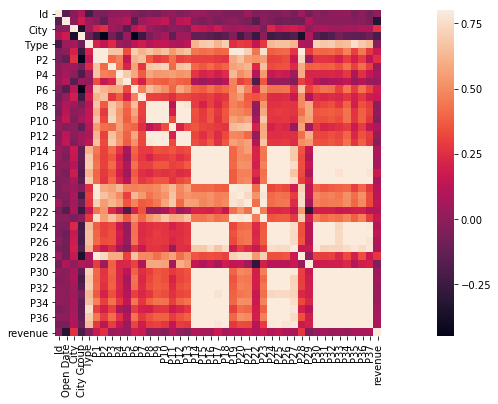

In [29]:
p_cols = ['Open Date','City', 'City Group', 'Type']
p_cols.extend( [ 'P{}'.format(n) for n in range(1,38)])
p_cols.extend(['revenue'])
for x in p_cols:
    label = preprocessing.LabelEncoder()
    # https://blog.csdn.net/weixin_38278334/article/details/82971752
    # 将离散型（字符）的数据转化为数据型 0 1 2 3
    df_train[x] = label.fit_transform(df_train[x])  
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(corrmat, vmax=0.8, square=True)

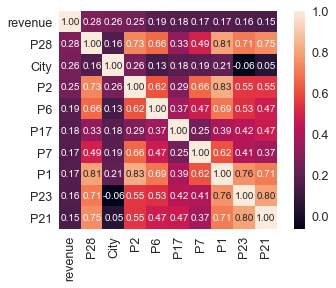

In [31]:
# 目测图不够准确，用数据筛选
k = 10
# 获取相关系数最大的前10个数据的索引    ！！！！！！！！！！获取的索引 后续可以【index】 或者 index.values
cols = corrmat.nlargest(k, 'revenue')['revenue'].index
# 相关矩阵  重新画一个图
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
# annot 格子显示数据  cbar 颜色条
# https://www.jianshu.com/p/c93db118ab98 参数简介
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# P28- 0.73P2 0.81P1 0.71P23 0.75P21
# P2 - 0.83P1
# P1 - 0.76P23 0.71 P21
# P23 - 0.8P21
# P2 P1 P23 P21

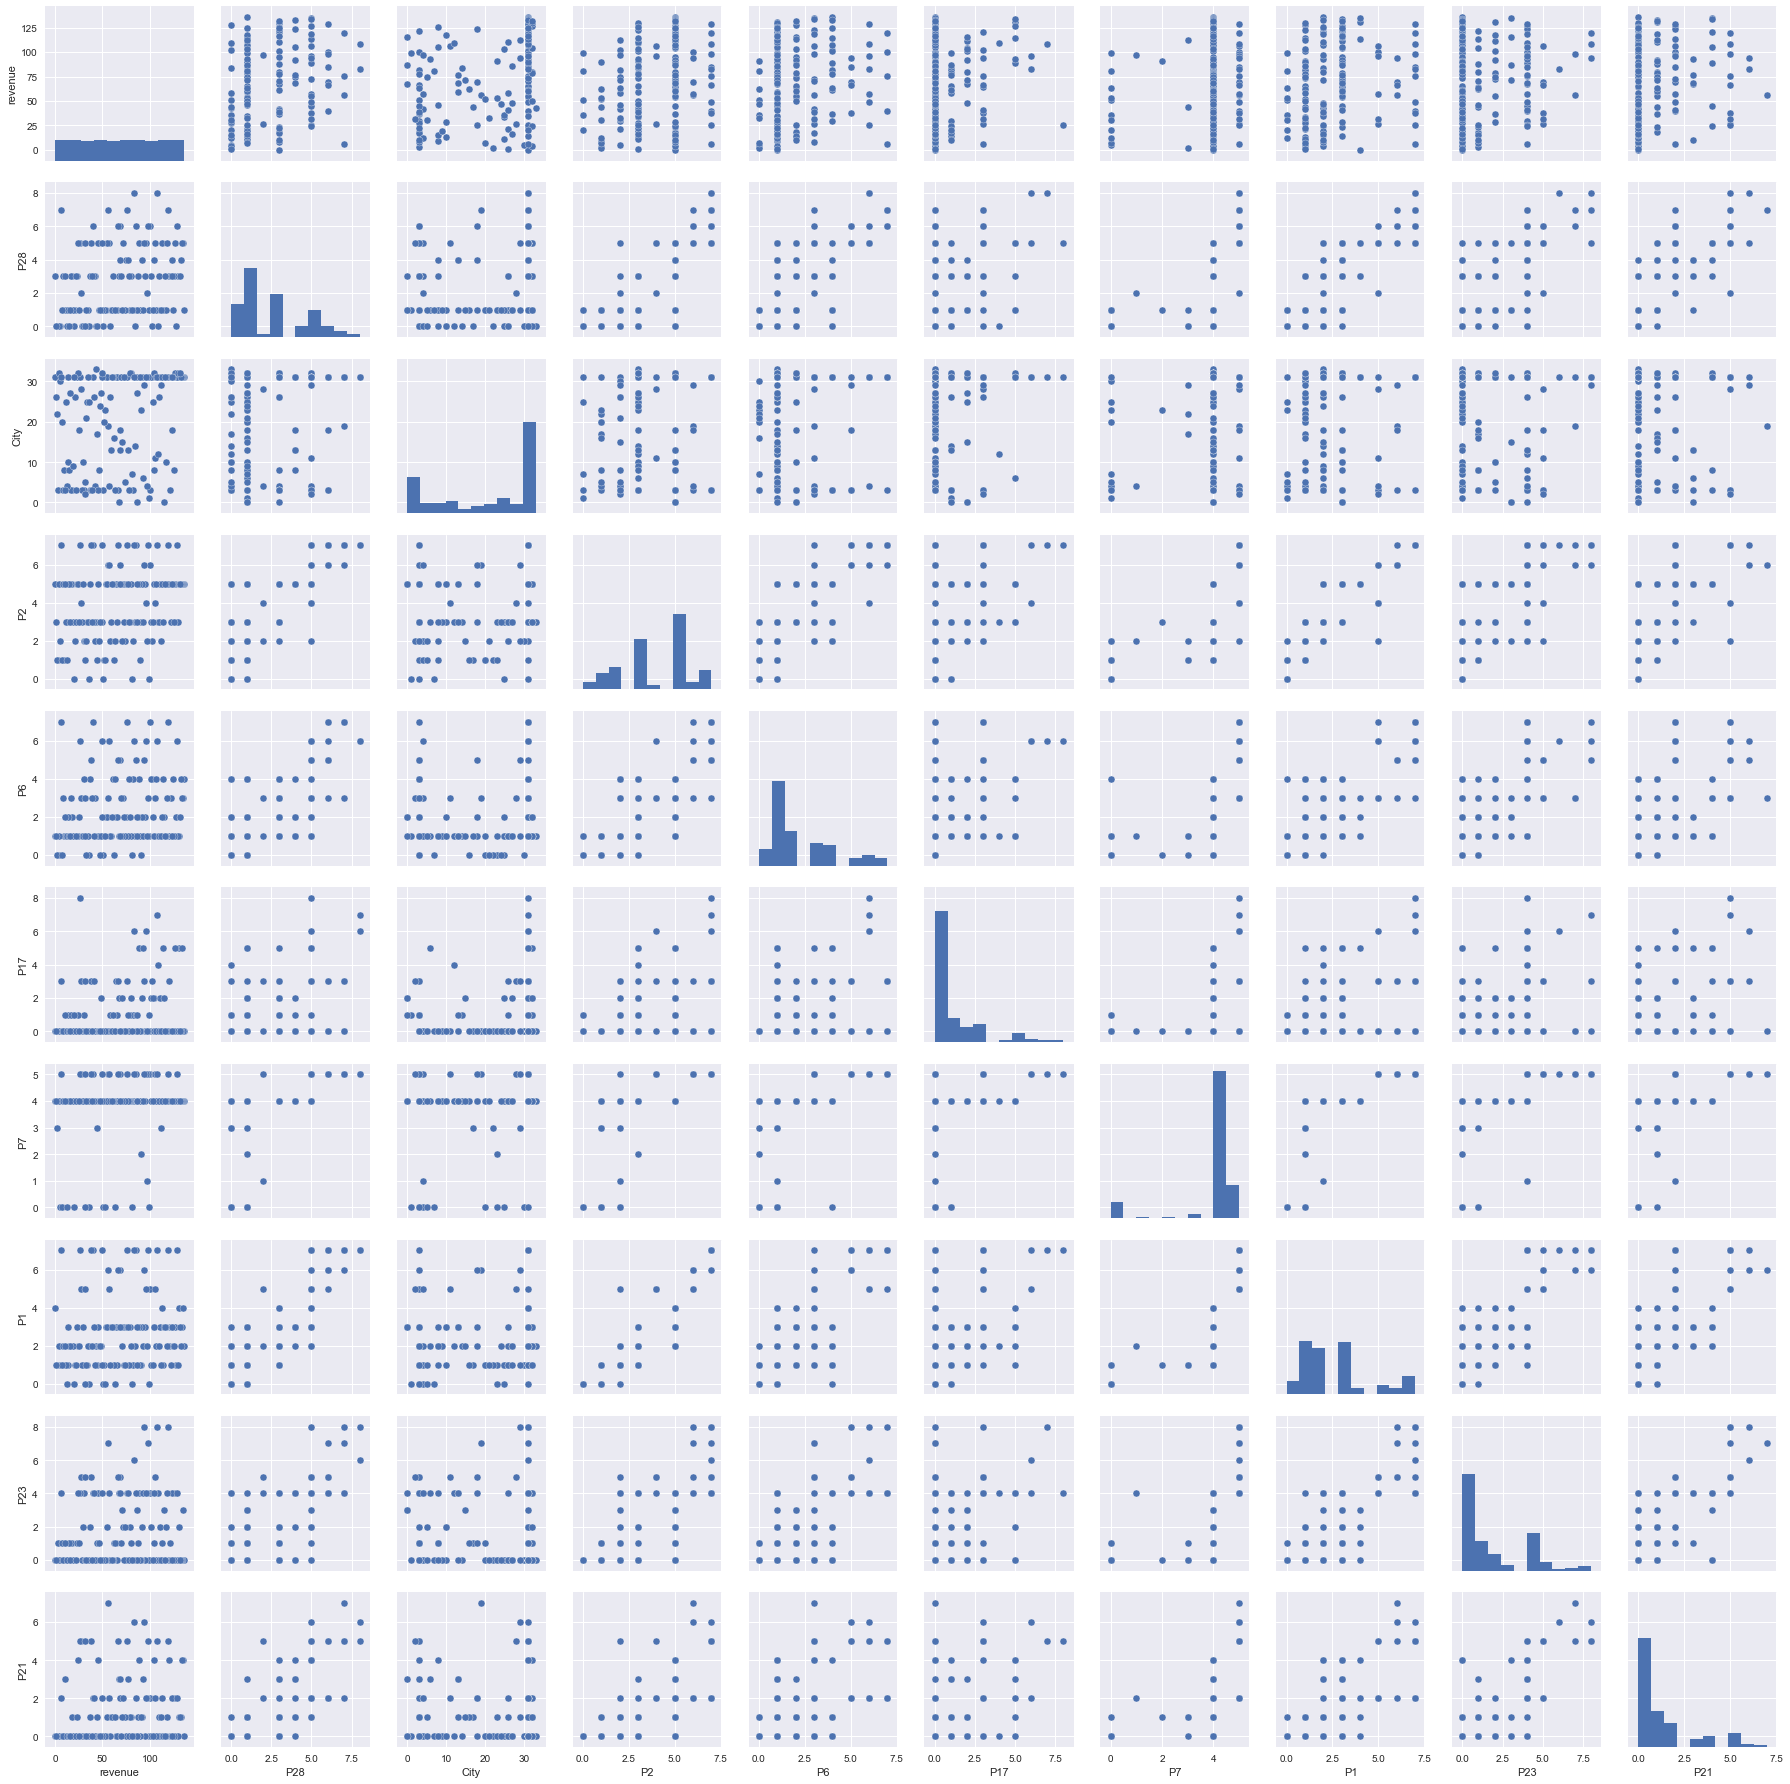

In [33]:
sns.set()
cols = ['revenue','P28','City', 'P2','P6', 'P17', 'P7', 'P1', 'P23', 'P21']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()
# 对角线图可以看出每个值的分布
# 上下三角的散点图可以看出每两个量的关系 （正负相关）

In [10]:
# P2 P1 P23 P21
df_train = pd.read_csv(r'E:\restaurant\train.csv\train.csv', parse_dates=['Open Date'])
df_test = pd.read_csv(r'E:\restaurant\test.csv\test.csv', parse_dates=['Open Date'])
drop_col = ['P2','P1','P23','P21']
df_train = df_train.drop(drop_col, axis=1)
df_joined = pd.concat([df_train.drop('revenue', axis=1), df_test], axis=0)  # 合并数据集

In [11]:
# 丢弃city列
X_train, X_test = prcs(df_joined.copy(), fe=['id', 'dummies', 'city'])

# Doble transformación para que la distribución sea Normal
y_train = df_train['revenue'].copy().apply(np.sqrt).apply(np.log)
models, scores = train_cv(X_train, y_train)
print(scores)

[1.20752707e+06 8.72356686e-01 2.38424999e+06 9.98157551e-02]


,Id,Open Date,City,City Group,Type,P3,P4,P5,P6,P7,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,1999-07-17,İstanbul,Big Cities,IL,4.0,4.0,2,2,5,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,2008-02-14,Ankara,Big Cities,FC,4.0,4.0,1,2,5,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,2013-03-09,Diyarbakır,Other,IL,2.0,5.0,2,3,5,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,2012-02-02,Tokat,Other,IL,6.0,6.0,4,4,10,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,2009-05-09,Gaziantep,Other,IL,3.0,4.0,2,2,5,...,3.0,5,1,3,2,3,4,3,3,4316715.0
